In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpl
import yfinance as yf

In [33]:
msft = yf.Ticker("GOOG")
# get 1mo data
hist = msft.history(period="3mo")

In [34]:
print(f"{hist.size}")
hist.head()

420


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-12-15 00:00:00-05:00,93.540001,94.029999,90.430000,91.199997,28298800,0,0
2022-12-16 00:00:00-05:00,91.199997,91.750000,90.010002,90.860001,48485500,0,0
2022-12-19 00:00:00-05:00,90.879997,91.199997,88.925003,89.150002,23020500,0,0
2022-12-20 00:00:00-05:00,88.730003,89.779999,88.040001,89.629997,21976800,0,0
2022-12-21 00:00:00-05:00,89.730003,90.915001,88.910004,90.250000,20336400,0,0


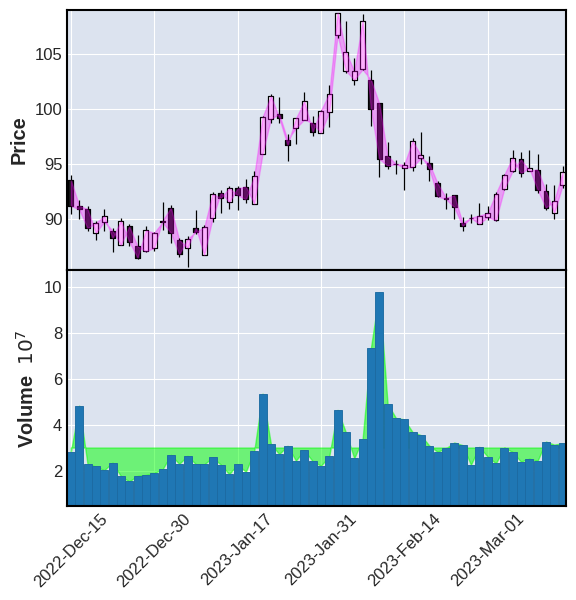

In [35]:
fb1 = dict(y1=hist['Open'].values  , y2=hist['Close'].values , panel=0, alpha=0.3, color='magenta')
fb2 = dict(y1=hist['Volume'].values, y2=hist['Volume'].mean(), panel=1, alpha=0.5, color='lime')

mpl.plot(hist,volume=True,panel_ratios=(1.1,1),
         type='candle',tight_layout=True,figratio=(1,1),
         fill_between=[fb1,fb2])

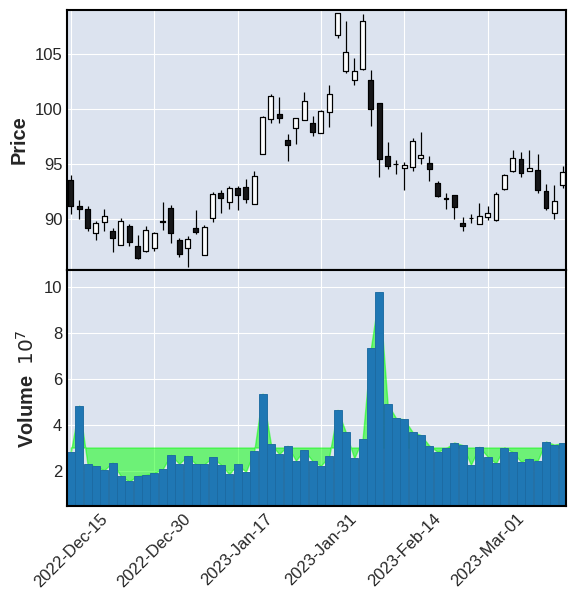

In [36]:

mpl.plot(hist,volume=True,panel_ratios=(1.1,1),
         type='candle',tight_layout=True,figratio=(1,1),
         fill_between=dict(y1=hist['Volume'].values,
                           y2=hist['Volume'].mean(),
                           panel=1,alpha=0.5,color='lime'))

In [37]:
def MACD(data: pd.DataFrame) -> tuple:
    ewm_12 = data["Close"].ewm(span=12, adjust=False).mean()
    ewm_26 = data["Close"].ewm(span=12, adjust=False).mean()
    macd = ewm_12 - ewm_26
    signal = macd.ewm(span=9, adjust=False).mean()
    histogram = macd - signal
    return ewm_12, ewm_26, macd, signal, histogram


#ewm_12, ewm_26, macd, signal, histogram = MACD(hist)


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


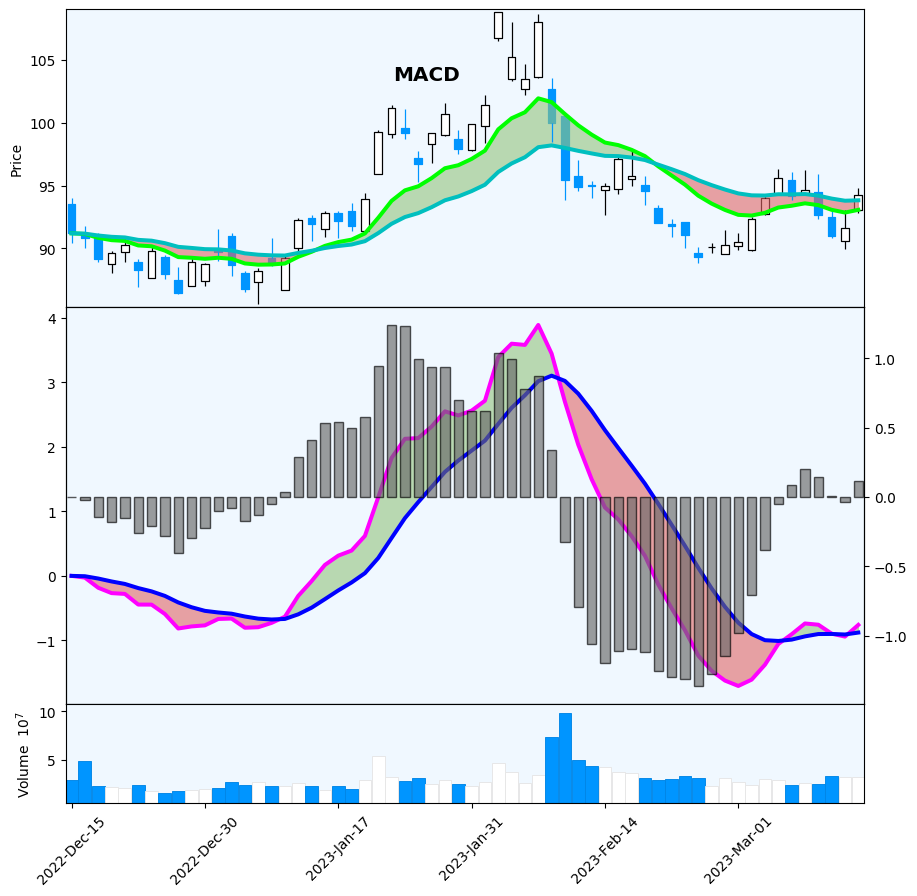

In [42]:
ewm_12 = hist["Close"].ewm(span=12, adjust=False).mean()
ewm_26 = hist["Close"].ewm(span=26, adjust=False).mean()
macd = ewm_12 - ewm_26
signal = macd.ewm(span=9, adjust=False).mean()
histogram = macd - signal
fb_12up = dict(y1=ewm_12.values,y2=ewm_26.values,where=ewm_12>ewm_26,color="#93c47d",alpha=0.6,interpolate=True)
fb_12dn = dict(y1=ewm_12.values,y2=ewm_26.values,where=ewm_12<ewm_26,color="#e06666",alpha=0.6,interpolate=True)
fb_exp12 = [fb_12up,fb_12dn]

fb_macd_up = dict(y1=macd.values,y2=signal.values,where=signal<macd,color="#93c47d",alpha=0.6,interpolate=True)
fb_macd_dn = dict(y1=macd.values,y2=signal.values,where=signal>macd,color="#e06666",alpha=0.6,interpolate=True)
fb_macd_up['panel'] = 1
fb_macd_dn['panel'] = 1


fb_macd = [fb_macd_up,fb_macd_dn]

apds = [mpl.make_addplot(ewm_12,color='lime'),
        mpl.make_addplot(ewm_26,color='c'),
        mpl.make_addplot(histogram,type='bar',width=0.7,panel=1,
                         color='dimgray',alpha=0.65,secondary_y=True),
        mpl.make_addplot(macd,panel=1,color='fuchsia',secondary_y=False),
        mpl.make_addplot(signal,panel=1,color='b',secondary_y=False)#,fill_between=fb_macd),
       ]

s = mpl.make_mpf_style(base_mpf_style='blueskies',facecolor='aliceblue')#,rc={'figure.facecolor':'lightcyan'})

mpl.plot(hist,type='candle',addplot=apds,figscale=1.6,figratio=(1,1),title='\n\nMACD',
         style=s,volume=True,volume_panel=2,panel_ratios=(3,4,1),tight_layout=True,
         fill_between=fb_macd+fb_exp12)

In [12]:
def ichimoku_indicator(data,
    tenkan=9,
    kijun=26,
    chiou=-26,
    senkou_a=26,
    senkou_b=52,
    chikou=None
):
    """ Implements Ichimoku momentum indicator.
    It requires  5 different components.
    
    1 - Tenkan-Sen aka Conversion line: midpoint of the last 9 candles.
        Computed by adding highest high and lowest low over 9 different
        periods and divided by 2.

    2 - Kijun-Sen aka Base line: midpoint of the last 26 candlesticks.
        Computed as Tenkan-Sen, but using 26 candlesticks.
        
    3 - Chiou aka Lagging span: lags behind price with 26 periods.
    
    4 - Senkou-A aka Leading span A: midpoint between the conversion line
        and the base line. Computed as (Conversion Line + Base Line) / 2.
        Plotted 26 periods in the future.
    
    5 - Senjou-B aka Leading span B: midpoint as the leading span A, but
        using 52 periods.
    
    6 - (Optional) Chikou span: Closing prices plotted 26 periods back
        in time.
    
    """
    ichimoku_data = data
    # conversion line
    tenkan_sen_high = data["High"].rolling(window=tenkan).max()
    tenkan_sen_low = data["Low"].rolling(window=tenkan).min()
    ichimoku_data["conversion_line"] = (tenkan_sen_high + tenkan_sen_low) / 2
    # base line
    kijun_sen_high = data["High"].rolling(window=kijun).max()
    kijun_sen_low = data["Low"].rolling(window=kijun).min()
    ichimoku_data["base_line"] = (kijun_sen_high + kijun_sen_low) / 2
    # leading span A
    leading_a = ((ichimoku_data["conversion_line"] + ichimoku_data["base_line"]) / 2
                ).shift(senkou_a)
    ichimoku_data["leading_a"] = leading_a
    # leading span B
    leading_b_high = data["High"].rolling(window=senkou_b).max()
    leading_b_low = data["Low"].rolling(window=senkou_b).min()
    leading_b = ((leading_b_high + leading_b_low) / 2).shift(senkou_b)
    ichimoku_data["leading_b"] = leading_b
    # chikou (Not implemented)
    
    return ichimoku_data

def process_data(data):
    """Process data into the desired format for different indicators"""
    output = pd.DataFrame({
        'Dates': data.index.values,
        'High': data["High"],
        'Low': data["Low"],
        'Open': data["Open"],
        'Close': data["Close"],
    })
    
    return output

def plot_all(raw_data):
    """Handles all plotting"""
    processed_data = process_data(raw_data)
    fig, ax = plt.subplots(figsize=(14, 8))
    plot_ichimoku_curves(processed_data, fig, ax)
    #fin.plot(processed_data, type="candle")
    plt.legend()
    plt.show()

def plot_ichimoku_curves(processed_data, fig, ax):
    """Plots ichimoku curves from processed data"""
    ichimoku_data = ichimoku_indicator(processed_data)
    date_axis = processed_data["Dates"]
    plt.title("Ichimoku Curves")
    plt.xlabel("Date", fontsize=7)
    plt.ylabel("Price", fontsize=7)
    plt.plot(ichimoku_data["Close"], label='close', color="black", linestyle='dashed')
    plt.plot(ichimoku_data["conversion_line"], label='conversion_line', color="purple")
    plt.plot(ichimoku_data["base_line"], label='base_line', color="darkblue")
    plt.plot(ichimoku_data["leading_a"], label='leading_a', color="green")
    plt.plot(ichimoku_data["leading_b"], label='leading_b', color="red")
    # green cloud
    ax.fill_between(ichimoku_data["Dates"],
                    ichimoku_data["leading_a"], ichimoku_data["leading_b"],
                    where=ichimoku_data["leading_a"] > ichimoku_data["leading_b"],
                   facecolor="green")
    # red cloud
    ax.fill_between(ichimoku_data["Dates"],
                    ichimoku_data["leading_a"], ichimoku_data["leading_b"],
                    where=ichimoku_data["leading_a"] <= ichimoku_data["leading_b"],
                   facecolor="red")

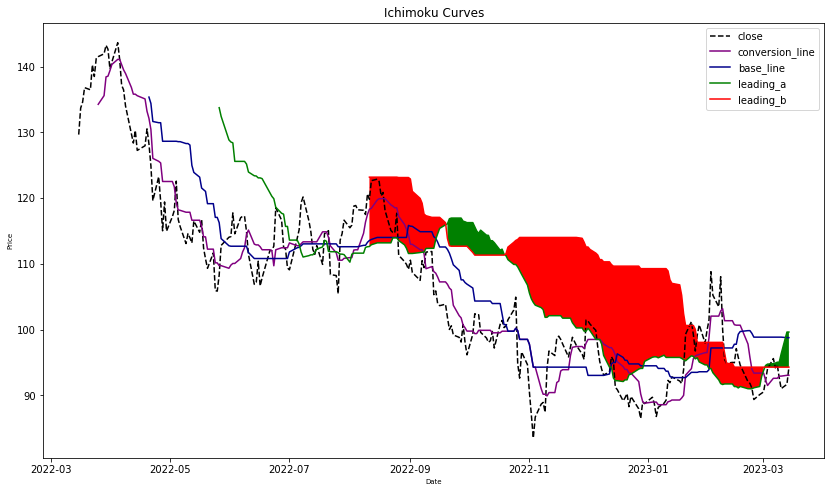

In [13]:
plot_all(hist)